# hurricane-net
Hammad Usmani
### A machine learning algorithm to forecast the intensity and trajectory of Atlantic tropical storms
[https://github.com/hammad93/hurricane-net](https://github.com/hammad93/hurricane-net)

### Table of Contents

1. [Background](#Background)
2. [Problem](#Problem)
3. [Datasets](#Datasets)
4. [Workflow Diagram](#Workflow)
5. [Data Extraction](#Extract)
6. [Data Transformation](#Transform)
7. [Data Loading](#Load)
8. [Feature Engineering](#FeatureEngineering)
9. [Model Architecture](#ModelArchitecture)
11. [Model Selection](#ModelSelection)
12. [Paramater Optimization](#Optimization)
13. [Model Evaluation & Benchmarks](#Benchmarks)
14. [Visualizations](#Visualizations)

![Hurricane Maria 2017](img/hurricane-maria.png "Hurricane Maria. Source: NOAA")

## Background<a id="Background"></a>

The National Hurricane Center (NHC) and National Oceanic and Atmospheric Administration (NOAA) provide predictions for storms trajectories, intensity, and size. They create these predictions based on models that can be classified into 3 groups: dynamical, statistical, and ensemble [1]. The most accurate models are based on computational fluid dynamics and achieve more precision than their statistical and ensemble counterparts [1][4]. The current statistical models (OCD5) are based on multiple regression methods that can explain a significant amount of variance [1]. In this project, we research and implement the domain of machine learning and deep learning into predictive hurricane models for both trajectory and intensity and evaluate them against the NHC standards. 
Previous research into machine learning to forecast tropical Atlantic storms include a sparse recurrent neural network (Kordmahalleh, Sefidmazgi, & Homaifar, 2016) and an artificial neural network (Jung & Das, 2013); both achieved favorable results. The hurricane models created can be utilized to develop more precise emergency planning. There is a necessity for more accurate and timely models that can help reduce the amount of loss caused by hurricanes. 

## Problem<a id="Problem"></a>

The NOAA and NHC have several different classifications for Atlantic hurricane models that describe feature prediction and model architecture. The 3 main classifications for hurricane model architecture include dynamical, statistical, and ensemble. Classifications also include relative compute time required to create an output grouped as either early or late and forecast parameters such as trajectory, intensity, and wind radii. The most accurate models are late models that take upwards of 6 hours to produce an output whereas models that can produce an output in seconds to minutes are called early. Early models tend to be statistical which include the baseline model for trajectory named CLIPER5 Climatology and Persistence (CLP5) utilizing multivariate regression. The performance for these methods can be augmented by incorporating more advanced statistical methods from deep learning such as recurrent neural networks. Kordmahalleh et al., 2016 created a sparse recurrent neural network augmented by a genetic algorithm but there are factors requiring improvement. The training set utilized an older version of the NHC Hurricane Database format known as HURDAT while a new format has been released called HURDAT2 with additional information on wind radii. Kordmahalleh et al., 2016 also utilized benchmarks different from the standard applied within the NHC. Other than improving their methodology, we can expand the scope by creating separate models for both intensity and trajectory. These models can be used to predict the trajectory and intensity for future Atlantic storms.

## Datasets<a id="Datasets"></a>

The following datasets and inputs including their sources will be used to create machine learning models:
- NHC Hurricane Database (HURDAT2)
    - http://www.nhc.noaa.gov/data/#hurdat
    - https://www.kaggle.com/noaa/hurricane-database
- NHC Forecast Error Database
    - http://www.nhc.noaa.gov/verification/verify7.shtml
- NHC GIS
    - http://www.nhc.noaa.gov/gis/
    
The NHC HURDAT2 database contains the tracking information for Atlantic tropical and subtropical cyclones which includes hurricanes and tropical storms from 1851 to 2016. The most updated version of the dataset is included on the noaa.gov site and includes 2 additional years of cyclone data compared to the data set available on Kaggle and is potentially more descriptive. To match the inputs of the baseline model used by the NHC, we are calculating the forward motion of the storm by applying a vector based on previous and current geographical location.

*Table 1. This table contains the tentative features as input to the model*

| **Name**         | **Data Type** | **Description**                                                     |
|------------------|---------------|---------------------------------------------------------------------|
| Time             | Date Time     | The date and time of the measurement.                               |
| Latitude         | Float         | The geographical latitude of the storm eye to 1 decimal precision.  |
| Longitude        | Float         | The geographical longitude of the storm eye to 1 decimal precision. |
| Maximum Winds    | Integer       | The maximum sustained winds within the storm.                       |
| Minimum Pressure | Integer       | The minimum barometric pressure within the storm.                   |
| Forward Motion   | String        | Calculated vector of motion based on location in time series.       |

The Forecast Error Database contains information on the accuracy of predicted models from the NHC. The two model forecast errors available are labeled OFCL and BCD5. The OFCL is the official NHC forecast and the BCD5 is the real track available. This data set can be used to benchmark and evaluate the deep learning model. 
The NOAA and NHC also hosts a geographical information system (GIS) that contains raw and processed data on hurricanes. The server hosting the GIS is publicly accessible and can be used to evaluate our model by comparing the 2017 Atlantic tropical season. The preliminary best tracks can be found here before they are finalized and available in the HURDAT2 data set. With the GIS, we can construct a final evaluation data set.

*Diagram 1. This graphic describes the workflow for the deep learning models*.<a id="Workflow"></a>
![Data Pipeline](img/Deep Learning Workflow.png "hurricane-net Data Pipeline")

## Extract Data<a id="Extract"></a>

*The following code uses the hurdat2 and models modules created to provide a class interface for the HURDAT2 and error forecast database located in the data and models folder. *

We will begin our steps to perform extraction, transformation, and loading of our data for analysis or broadly known as ETL. Although we're dividing these steps into disctinct procedures, they are often more fluid and often have overlaps. The extraction phase consists of collecting and parsing the HURDAT2 and error forecast databases for analysis and benchmarking. The HURDAT2 database is our core foundation for creating the deep learning model. We store the database in its raw .txt format but it can be directly linked to the database hosted by the NHC.

In [1]:
# Import various libraries throughout the software
from pprint import pprint
import numpy as np
import datetime
import dateutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

# Import from hurdat2 class in data folder and models class from hurricane-models folder
from data.hurdat2 import hurdat2
from errors.models import models

# Initialize Dataframe for hurricanes and error database
dataset = hurdat2("data/hurdat2.txt")
errors = models("errors/1970-present_OFCL_v_BCD5_ind_ATL_TI_errors_noTDs.txt")

# Show the first 5 records from Hurricane Katrina 2005 (AL122005)
dataset.hurricanes.query('storm_id == "AL122005"').head()

,storm_id,storm_name,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,34kt_ne,...,34kt_sw,34kt_nw,50kt_ne,50kt_se,50kt_sw,50kt_nw,64kt_ne,64kt_se,64kt_sw,64kt_nw
44063,AL122005,KATRINA,2005-08-23 18:00:00,,TD,23.1N,75.1W,30,1008,0,...,0,0,0,0,0,0,0,0,0,0
44064,AL122005,KATRINA,2005-08-24 00:00:00,,TD,23.4N,75.7W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44065,AL122005,KATRINA,2005-08-24 06:00:00,,TD,23.8N,76.2W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44066,AL122005,KATRINA,2005-08-24 12:00:00,,TS,24.5N,76.5W,35,1006,60,...,0,0,0,0,0,0,0,0,0,0
44067,AL122005,KATRINA,2005-08-24 18:00:00,,TS,25.4N,76.9W,40,1003,60,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# Show the first 3 OFCL hurricane model errors for Hurricane Katrina 2005 on 28-08-2005/18:00:00
pprint(errors.models['OFCL'].storm['AL122005'][datetime.datetime(2005, 8, 28, 18, 0)], indent = 8)

{       'intensity_forecast': {       datetime.datetime(2005, 8, 28, 18, 0): 0.0,
                                      datetime.datetime(2005, 8, 29, 6, 0): 20.9,
                                      datetime.datetime(2005, 8, 29, 18, 0): 93.6,
                                      datetime.datetime(2005, 8, 30, 6, 0): 170.2,
                                      datetime.datetime(2005, 8, 30, 18, 0): None,
                                      datetime.datetime(2005, 8, 31, 18, 0): None,
                                      datetime.datetime(2005, 9, 1, 18, 0): None,
                                      datetime.datetime(2005, 9, 2, 18, 0): None,
                                      datetime.datetime(2005, 9, 3, 18, 0): None,
                                      datetime.datetime(2005, 9, 4, 18, 0): None},
        'lat': 26.3,
        'long': 88.6,
        'sample_sizes': {       'F012': 0.33,
                                'F024': 0.33,
                                'F036': 

## Transform Data<a id="Transform"></a>

The following code will tranform the hurricane best path data into objects that can be better manipulated for processing. to match between datasets, we will also create a `storm_id` dictionary to store storm names matched with ID's.

In [3]:
# Create hurricane class
class hurricane(object) : 
    def __init__(self, name, id) :
        # Set instance variables
        self.name = name
        self.id = id
        self.entries = dict()
        self.models = dict()
        
        return
    # Add hurricane track entry based on standard HURDAT2 format
    def add_entry(self, array) :
        entry = {
            array[0] : { # dateteime of entry
                'entry_time' : array[0], 
                'entry_id' : array[1],
                'entry_status' : array[2],
                'lat' : float(array[3][:-1]), # Convert to number from format '#.#N'
                'long' : float(array[4][:-1]), # Convert to number from format '#.#W'
                'max_wind' : float(array[5]),
                'min_pressure' : None if array[6] is None else float(array[6]), # Early records are -999 or None
                'wind_radii' :  array[7:], # Array based on HURDAT2 format
            }
        }
        self.entries.update(entry)
        
        return
    # Add hurricane model errors
    def add_model(self, name, model) :
        self.models[name] = model
        
        return
# Storm ID Key for matching between datasets
storm_id = dict()

# Parse in hurricanes
hurricanes = dict()
print("Transforming HURDAT2 into objects . . .")
for index, entry in dataset.hurricanes.iterrows() :
    print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset.hurricanes)), end = "\r")
    # New hurricane
    if entry['storm_id'] not in hurricanes :
        hurricanes[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_id[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes[entry['storm_id']].add_entry(entry[2:])
print("\nDone!")

Transforming HURDAT2 into objects . . .
Transforming 49691/49691 entries from HURDAT2
Done!


## Load Data<a id="Load"></a>

The following will finalize our preliminary data preparation by loading some of the errors into each hurricane object. Note that models start from the year 1970 and any hurricane before that has no previous model data.

In [4]:
# Get all available model errors
models = errors.models.keys()
# Load model errors into hurricanes
for id in storm_id :
    for model in models :
        # Skip if this hurricane does not have the model
        if id not in errors.models[model].storm :
            continue
        hurricanes[id].add_model(model, errors.models[model].storm[id])

## Feature Engineering & Data Augmentation<a id="FeatureEngineering"></a>

The following section will extract the relevant features and engineer each data point so that we can fit it into the model. Because the type of inputs are important, the features will be transformed based on the model architecture. This will also include data augmentation methods. The higher level architecture will be a deep learning recurrent neural network with LSTM and time distributed layers.

The current statistical baseline model using multivariate regression uses multiple predictors as input. According to Knaff 2013, the following predictors were calculated for their intensity model that were not included in the HURDAT2 database. These features can be calculated from the data loaded into our current object model.

1. Date Information
2. Zonal Speed Of The Storm (U) (kt)
3. Meridional Speed Of The Storm (V) (kt)
4. 12-h Change In Intensity (DVMX) (kt)

The shape on the input to the LSTM will be in a 3D array with the format [samples, timestamps, features]. We will intitially begin with 1 time step and evaluate more can benefit our model. The output requires a 5 day forecast and observations without track data 5 days in the future will not be used.

In [5]:
def feature_extraction(timestep, previous) :
    '''
    PURPOSE: Calculate the features for a machine learning model within the context of hurricane-net
    METHOD: Use the predictors and the calculation methodology defined in Knaff 2013
    INPUT:  timestep - current dictionary of features in the hurricane object format
            previous - previous timestep dictionary of features in the hurricane object format
    OUTPUT: Dictionary of features
    '''
    features = {
        'lat' : timestep['lat'],
        'long' : timestep['long'],
        'max_wind' : timestep['max_wind'],
        'delta_wind' : (timestep['max_wind'] - previous['max_wind']) / # Calculated from track (12h)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200),
        'min_pressure' : timestep['min_pressure'], 
        'zonal_speed' : (timestep['lat'] - previous['lat'])/ # Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'meridonal_speed' : (timestep['long'] - previous['long'])/# Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'year' : timestep['entry_time'].year,
        'month' : timestep['entry_time'].month,
        'day' : timestep['entry_time'].day,
        'hour' : timestep['entry_time'].hour,
    }
    return features
    
def storm_x_y(storm, timesteps = 1, lag = 24) :
    '''
    PURPOSE: Create independent and dependent samples for a machine learning model based on the timesteps
    METHOD: Use the HURDAT2 database and a hurricane object as defined in hurricane-net for feature extraction
    INPUT:  storm - hurricane object
            timesteps - (default = 1) number of timesteps to calculate
            include_none - (default = False) Boolean for including None in test data. Imputing function unavailable.
            lag - (default = 24) lag in hours for the dependent variables up to 5 days
    OUTPUT: Dictionary with independent (x) and dependent (y) values.
    '''
    x = []
    # Create testing data structure with a dictionary
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    y = dict([(time,[]) for time in times])
    
    # Sort by entry time
    entries = [entry[1] for entry in sorted(storm.entries.items())]
    
    for index in range(len(entries)) :
        if index < timesteps : # Flag for insufficient initial time steps
            continue

        # If we're not including None values, check to see if there will be any
        if None in [storm.entries.get(entries[index]['entry_time'] +
                                         datetime.timedelta(hours = future)) for future in times] : break
            
        # Calculate time steps and their features for independent values
        sample = []
        for step in range(timesteps) :
            # Training sample
            timestep = entries[index - step]
            previous = entries[index - step - 1]
            sample.append([timestep['entry_time']] + [[feature_extraction(timestep, previous)]])
        x.append(sample) # Add our constructed sample
        
        # Calculate time steps and their features for dependent values
        for future in times :
            timestep = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future))
            previous = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future - lag))
            
            if timestep and previous: 
                y[future].append(feature_extraction(timestep, previous))
            else :
                y[future].append(None)
    
    # Return output, if there is no output, return None.
    if len(x) is 0 :
        return None
    else:
        return {'x': x, 'y': y}
def shape(hurricanes, timesteps, remove_missing = True) :
    '''
    PURPOSE: Shape our data for input into machine learning models
    METHOD: Use a numpy array to shape into (samples, timesteps, features)
    INPUT:  hurricanes - dictionary of hurricane objects
            timesteps - number of timesteps for the shape
            remove_missing - boolean indicating whether the algorithm will disregard missing values
    OUTPUT: numpy array of shape (samples, timesteps, 11) where 11 is the number of predictors in a hurricane object
    '''
    x = []
    y = []
    lag = 24 # lag time in hours
    precision = np.float64 # defines the precision of our data type
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    count = 0
    for hurricane in hurricanes.values() :
        count += 1
        result = storm_x_y(hurricane, timesteps, lag)
        if result is None :
            continue
        # Extract only the values from the strom features using our specified precision
        hurricane_x = np.array(
            [[list(sample[1][0].values()) for sample in x] for x in result['x']],
            dtype = precision)
        hurricane_y = np.array(
            [[list(result['y'][time][index].values()) for time in times] for index in range(len(result['y'][lag]))],
            dtype = precision)
        # Disregard if algorithm requires no missing values
        if remove_missing :
            if (len(np.where(np.isnan(hurricane_x))[0]) > 0) or (len(np.where(np.isnan(hurricane_y))[0]) > 0) :
                continue
        # Add to our results
        x.extend(hurricane_x)
        y.extend(hurricane_y)
        print("Feature engineered {}/{} hurricanes for {} timestep(s)".format(count, len(hurricanes), timesteps), end = "\r")
    print("\nDone feature engineering hurricanes.")
    
    return {'x': np.array(x), 'y': np.array(y)}
def scaler(processed_data, hurricanes) :
    '''
    PURPOSE: Scale our data using the RobustScaler method from the sklearn library
    METHOD: Generate data using 1 timesteps and then remove the NaN or None types to use the scaler methods
    INPUT:  hurricanes - dictionary of hurricane objects
            processed_data - dictionary of x and y values of data produced by shape() function with no missing values
    OUTPUT: 1) Scaled processed_data using RobustScaler
            2) RobustScaler object fit with appropriate data
    '''
    print("Scaling Data . . . (1 timestep for unqiue data)")
    # Create our scaler
    unqiue_data = shape(hurricanes, timesteps = 1)
    x = np.reshape(unqiue_data['x'], (unqiue_data['x'].shape[0], -1))
    x = np.delete(x, np.where(np.isnan(x))[0], 0)
    scaler = RobustScaler()
    scaler.fit(x)
    
    # Scale our data
    for index in range(len(processed_data['x'])) :
        # Scale our x
        processed_data['x'][index] = scaler.transform(processed_data['x'][index])
        # Scale our y
        processed_data['y'][index] = scaler.transform(processed_data['y'][index])
    print("Done scaling.")
    return processed_data, scaler
# Finalize and scale procesed data into a dictionary
preprocessed_data = shape(hurricanes, timesteps = 5)
processed_data, scaler = scaler(preprocessed_data, hurricanes)

Feature engineered 1830/1830 hurricanes for 5 timestep(s)
Done feature engineering hurricanes.
Scaling Data . . . (1 timestep for unqiue data)
Feature engineered 1830/1830 hurricanes for 1 timestep(s)
Done feature engineering hurricanes.
Done scaling.


## Model Architecture<a id="ModelArchitecture"></a>

Following feature engineering, we are now ready to input our data into a machine learning algorithm. The scope of this project will attempt a deep learning approach to forecasting Atlantic tropical cyclones. We will experiment with nunermous different architectures but we will focus around a Recurrent Neural Network utilizing LSTM cells.

Notes:
- We will use 500 epochs for wind intensity because the validation loss is not decresing
- We will use 1,000 epochs for latitute and longitude

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from sklearn import model_selection

# Create our cross validation data structure
X_train, X_test, y_train, y_test = model_selection.train_test_split(processed_data['x'], processed_data['y'],
                                                                    test_size = 0.2)

# Train for wind intensity
y_train_wind = np.array([[[features[2]] for features in y] for y in y_train], dtype = np.float64)
y_test_wind = np.array([[[features[2]] for features in y] for y in y_test], dtype = np.float64)

# Train for latitude and longitude location
y_train_lat = np.array([[[features[0]] for features in y] for y in y_train], dtype = np.float64)
y_test_lat = np.array([[[features[0]] for features in y] for y in y_test], dtype = np.float64)
y_train_long = np.array([[[features[1]] for features in y] for y in y_train], dtype = np.float64)
y_test_long = np.array([[[features[1]] for features in y] for y in y_test], dtype = np.float64)


def bd_lstm_td(X_train, y_train, X_test, y_test, n_epochs = 500) :    
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 1024, return_sequences = True, dropout = 0.05),
                            input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(units = 512, return_sequences = True, dropout = 0.05))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mae', optimizer='adam')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs,
                        validation_data = (X_test, y_test))
    return model, history

def lstm_td(X_train, X_test, y_train, y_test) :
    model = Sequential()
    model.add(LSTM(units = 1024, input_shape = (5,8), return_sequences = True))
    model.add(TimeDistributed(Dense(8)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    model.fit(X_train, y_train, batch_size = len(X_train), epochs = 300)
    
    return model

model_wind, model_wind_history = bd_lstm_td(X_train, y_train_wind, X_test, y_test_wind)
model_lat, model_lat_history = bd_lstm_td(X_train, y_train_lat, X_test, y_test_lat, n_epochs = 1000)
model_long, model_long_history = bd_lstm_td(X_train, y_train_long, X_test, y_test_long, n_epochs = 1000)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 5, 2048)           8486912   
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 512)            5244928   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              513       
Total params: 13,732,353
Trainable params: 13,732,353
Non-trainable params: 0
_________________________________________________________________
None
Train on 3298 samples, validate on 825 samples
Epoch 1/500
3298/3298 [==============================] - 8s 2ms/step - loss: 0.7058 - val_loss: 0.6104
Epoch 2/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.6021 - val_loss: 0.5843
Epoch 3/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.5731 - val_loss: 0.5577
Epoch 4/500
3298/3298 [==========

Epoch 73/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4087 - val_loss: 0.4183
Epoch 74/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4102 - val_loss: 0.4155
Epoch 75/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.4072 - val_loss: 0.4154
Epoch 76/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4068 - val_loss: 0.4168
Epoch 77/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4070 - val_loss: 0.4151
Epoch 78/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4051 - val_loss: 0.4109
Epoch 79/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4038 - val_loss: 0.4124
Epoch 80/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4040 - val_loss: 0.4100
Epoch 81/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4021 - val_loss: 0.4098
Epoch 82/500
3298/3298 [==============================] - 4s 1ms

Epoch 152/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.3100 - val_loss: 0.3203
Epoch 153/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.3089 - val_loss: 0.3109
Epoch 154/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2984 - val_loss: 0.3139
Epoch 155/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.3002 - val_loss: 0.3079
Epoch 156/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2981 - val_loss: 0.3062
Epoch 157/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2941 - val_loss: 0.3069
Epoch 158/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2896 - val_loss: 0.3066
Epoch 159/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2880 - val_loss: 0.3018
Epoch 160/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2878 - val_loss: 0.3008
Epoch 161/500
3298/3298 [==============================

3298/3298 [==============================] - 4s 1ms/step - loss: 0.1873 - val_loss: 0.2051
Epoch 231/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1904 - val_loss: 0.2019
Epoch 232/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1874 - val_loss: 0.2024
Epoch 233/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1842 - val_loss: 0.2003
Epoch 234/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1832 - val_loss: 0.1974
Epoch 235/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1829 - val_loss: 0.1965
Epoch 236/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1833 - val_loss: 0.1999
Epoch 237/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1805 - val_loss: 0.1989
Epoch 238/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1809 - val_loss: 0.1961
Epoch 239/500
3298/3298 [==============================] - 4s 1ms/ste

Epoch 309/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1362 - val_loss: 0.1589
Epoch 310/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1392 - val_loss: 0.1624
Epoch 311/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1379 - val_loss: 0.1590
Epoch 312/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1397 - val_loss: 0.1598
Epoch 313/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1346 - val_loss: 0.1577
Epoch 314/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1334 - val_loss: 0.1591
Epoch 315/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1332 - val_loss: 0.1596
Epoch 316/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1364 - val_loss: 0.1571
Epoch 317/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1321 - val_loss: 0.1543
Epoch 318/500
3298/3298 [==============================

3298/3298 [==============================] - 4s 1ms/step - loss: 0.1138 - val_loss: 0.1460
Epoch 388/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1152 - val_loss: 0.1407
Epoch 389/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1099 - val_loss: 0.1414
Epoch 390/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1086 - val_loss: 0.1426
Epoch 391/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1083 - val_loss: 0.1423
Epoch 392/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1077 - val_loss: 0.1422
Epoch 393/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1113 - val_loss: 0.1395
Epoch 394/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1092 - val_loss: 0.1441
Epoch 395/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1100 - val_loss: 0.1389
Epoch 396/500
3298/3298 [==============================] - 4s 1ms/ste

Epoch 466/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0947 - val_loss: 0.1325
Epoch 467/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0932 - val_loss: 0.1336
Epoch 468/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0927 - val_loss: 0.1318
Epoch 469/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0926 - val_loss: 0.1333
Epoch 470/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0957 - val_loss: 0.1324
Epoch 471/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0912 - val_loss: 0.1332
Epoch 472/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0940 - val_loss: 0.1337
Epoch 473/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0958 - val_loss: 0.1315
Epoch 474/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0917 - val_loss: 0.1351
Epoch 475/500
3298/3298 [==============================

Epoch 37/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.2655 - val_loss: 0.2540
Epoch 38/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2635 - val_loss: 0.2534
Epoch 39/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2632 - val_loss: 0.2526
Epoch 40/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2640 - val_loss: 0.2532
Epoch 41/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2637 - val_loss: 0.2536
Epoch 42/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2626 - val_loss: 0.2521
Epoch 43/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2626 - val_loss: 0.2504
Epoch 44/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2613 - val_loss: 0.2490
Epoch 45/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2599 - val_loss: 0.2488
Epoch 46/1000
3298/3298 [==============================

Epoch 115/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2316 - val_loss: 0.2316
Epoch 116/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2308 - val_loss: 0.2324
Epoch 117/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2309 - val_loss: 0.2343
Epoch 118/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2363 - val_loss: 0.2412
Epoch 119/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2407 - val_loss: 0.2297
Epoch 120/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2324 - val_loss: 0.2297
Epoch 121/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2290 - val_loss: 0.2349
Epoch 122/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2317 - val_loss: 0.2302
Epoch 123/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2319 - val_loss: 0.2290
Epoch 124/1000
3298/3298 [====================

Epoch 193/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1903 - val_loss: 0.1944
Epoch 194/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1857 - val_loss: 0.1959
Epoch 195/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1872 - val_loss: 0.1930
Epoch 196/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1891 - val_loss: 0.1893
Epoch 197/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1833 - val_loss: 0.1932
Epoch 198/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1881 - val_loss: 0.1934
Epoch 199/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1857 - val_loss: 0.1901
Epoch 200/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1839 - val_loss: 0.1885
Epoch 201/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1855 - val_loss: 0.1870
Epoch 202/1000
3298/3298 [====================

Epoch 271/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1442 - val_loss: 0.1479
Epoch 272/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1432 - val_loss: 0.1451
Epoch 273/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1389 - val_loss: 0.1414
Epoch 274/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1383 - val_loss: 0.1411
Epoch 275/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1405 - val_loss: 0.1439
Epoch 276/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1381 - val_loss: 0.1419
Epoch 277/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1360 - val_loss: 0.1414
Epoch 278/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1367 - val_loss: 0.1397
Epoch 279/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1368 - val_loss: 0.1385
Epoch 280/1000
3298/3298 [====================

Epoch 349/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1113 - val_loss: 0.1119
Epoch 350/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1109 - val_loss: 0.1078
Epoch 351/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1045 - val_loss: 0.1056
Epoch 352/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1058 - val_loss: 0.1092
Epoch 353/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1050 - val_loss: 0.1021
Epoch 354/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1015 - val_loss: 0.1094
Epoch 355/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1080 - val_loss: 0.1060
Epoch 356/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1000 - val_loss: 0.1054
Epoch 357/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1053 - val_loss: 0.1047
Epoch 358/1000
3298/3298 [====================

Epoch 427/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0851 - val_loss: 0.0881
Epoch 428/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0852 - val_loss: 0.0866
Epoch 429/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0869 - val_loss: 0.0875
Epoch 430/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0834 - val_loss: 0.0849
Epoch 431/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0784 - val_loss: 0.0854
Epoch 432/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0803 - val_loss: 0.0846
Epoch 433/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0841 - val_loss: 0.0850
Epoch 434/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0818 - val_loss: 0.0844
Epoch 435/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0819 - val_loss: 0.0825
Epoch 436/1000
3298/3298 [====================

Epoch 505/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0697 - val_loss: 0.0732
Epoch 506/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0667 - val_loss: 0.0753
Epoch 507/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0697 - val_loss: 0.0738
Epoch 508/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0705 - val_loss: 0.0797
Epoch 509/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0719 - val_loss: 0.0759
Epoch 510/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0728 - val_loss: 0.0743
Epoch 511/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0677 - val_loss: 0.0752
Epoch 512/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0716 - val_loss: 0.0741
Epoch 513/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0724 - val_loss: 0.0794
Epoch 514/1000
3298/3298 [====================

Epoch 583/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0619 - val_loss: 0.0661
Epoch 584/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0623 - val_loss: 0.0706
Epoch 585/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0637 - val_loss: 0.0680
Epoch 586/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0639 - val_loss: 0.0699
Epoch 587/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0641 - val_loss: 0.0680
Epoch 588/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0602 - val_loss: 0.0666
Epoch 589/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0633 - val_loss: 0.0704
Epoch 590/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0639 - val_loss: 0.0654
Epoch 591/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0607 - val_loss: 0.0667
Epoch 592/1000
3298/3298 [====================

Epoch 661/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0565 - val_loss: 0.0657
Epoch 662/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0610 - val_loss: 0.0641
Epoch 663/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0570 - val_loss: 0.0670
Epoch 664/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0594 - val_loss: 0.0626
Epoch 665/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0599 - val_loss: 0.0670
Epoch 666/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0596 - val_loss: 0.0646
Epoch 667/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0579 - val_loss: 0.0607
Epoch 668/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0574 - val_loss: 0.0636
Epoch 669/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0562 - val_loss: 0.0632
Epoch 670/1000
3298/3298 [====================

Epoch 739/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0537 - val_loss: 0.0597
Epoch 740/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0495 - val_loss: 0.0574
Epoch 741/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0490 - val_loss: 0.0590
Epoch 742/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0523 - val_loss: 0.0632
Epoch 743/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0529 - val_loss: 0.0610
Epoch 744/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0514 - val_loss: 0.0605
Epoch 745/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0513 - val_loss: 0.0598
Epoch 746/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0501 - val_loss: 0.0577
Epoch 747/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0527 - val_loss: 0.0655
Epoch 748/1000
3298/3298 [====================

Epoch 817/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0471 - val_loss: 0.0591
Epoch 818/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0482 - val_loss: 0.0554
Epoch 819/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0476 - val_loss: 0.0580
Epoch 820/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0486 - val_loss: 0.0582
Epoch 821/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0488 - val_loss: 0.0574
Epoch 822/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0475 - val_loss: 0.0579
Epoch 823/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0459 - val_loss: 0.0574
Epoch 824/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0453 - val_loss: 0.0556
Epoch 825/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0466 - val_loss: 0.0570
Epoch 826/1000
3298/3298 [====================

Epoch 895/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0424 - val_loss: 0.0542
Epoch 896/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0443 - val_loss: 0.0560
Epoch 897/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0451 - val_loss: 0.0560
Epoch 898/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0444 - val_loss: 0.0542
Epoch 899/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0430 - val_loss: 0.0552
Epoch 900/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0430 - val_loss: 0.0546
Epoch 901/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0432 - val_loss: 0.0533
Epoch 902/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0429 - val_loss: 0.0560
Epoch 903/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0422 - val_loss: 0.0535
Epoch 904/1000
3298/3298 [====================

Epoch 973/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0395 - val_loss: 0.0543
Epoch 974/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0398 - val_loss: 0.0511
Epoch 975/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0420 - val_loss: 0.0554
Epoch 976/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0412 - val_loss: 0.0519
Epoch 977/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0397 - val_loss: 0.0511
Epoch 978/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0392 - val_loss: 0.0558
Epoch 979/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0407 - val_loss: 0.0526
Epoch 980/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0401 - val_loss: 0.0530
Epoch 981/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0400 - val_loss: 0.0534
Epoch 982/1000
3298/3298 [====================

Epoch 44/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1896 - val_loss: 0.1769
Epoch 45/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1914 - val_loss: 0.1763
Epoch 46/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1902 - val_loss: 0.1755
Epoch 47/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1896 - val_loss: 0.1753
Epoch 48/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1883 - val_loss: 0.1755
Epoch 49/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1875 - val_loss: 0.1764
Epoch 50/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1889 - val_loss: 0.1761
Epoch 51/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1873 - val_loss: 0.1755
Epoch 52/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1860 - val_loss: 0.1749
Epoch 53/1000
3298/3298 [==============================

Epoch 122/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1688 - val_loss: 0.1614
Epoch 123/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1673 - val_loss: 0.1590
Epoch 124/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1642 - val_loss: 0.1601
Epoch 125/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1654 - val_loss: 0.1591
Epoch 126/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1635 - val_loss: 0.1589
Epoch 127/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1641 - val_loss: 0.1627
Epoch 128/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1660 - val_loss: 0.1593
Epoch 129/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1652 - val_loss: 0.1608
Epoch 130/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1671 - val_loss: 0.1600
Epoch 131/1000
3298/3298 [====================

Epoch 200/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1415 - val_loss: 0.1370
Epoch 201/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1410 - val_loss: 0.1352
Epoch 202/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1419 - val_loss: 0.1329
Epoch 203/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1378 - val_loss: 0.1300
Epoch 204/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1365 - val_loss: 0.1340
Epoch 205/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1402 - val_loss: 0.1371
Epoch 206/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1429 - val_loss: 0.1307
Epoch 207/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1370 - val_loss: 0.1327
Epoch 208/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1372 - val_loss: 0.1330
Epoch 209/1000
3298/3298 [====================

Epoch 278/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1061 - val_loss: 0.1049
Epoch 279/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1049 - val_loss: 0.0991
Epoch 280/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1053 - val_loss: 0.1073
Epoch 281/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1097 - val_loss: 0.1009
Epoch 282/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1024 - val_loss: 0.0994
Epoch 283/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0994 - val_loss: 0.1013
Epoch 284/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0997 - val_loss: 0.1007
Epoch 285/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1021 - val_loss: 0.1001
Epoch 286/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1036 - val_loss: 0.0998
Epoch 287/1000
3298/3298 [====================

Epoch 356/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0793 - val_loss: 0.0763
Epoch 357/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0793 - val_loss: 0.0784
Epoch 358/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0782 - val_loss: 0.0767
Epoch 359/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0803 - val_loss: 0.0774
Epoch 360/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0773 - val_loss: 0.0750
Epoch 361/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0795 - val_loss: 0.0798
Epoch 362/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0798 - val_loss: 0.0763
Epoch 363/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0785 - val_loss: 0.0761
Epoch 364/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0783 - val_loss: 0.0796
Epoch 365/1000
3298/3298 [====================

Epoch 434/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0685 - val_loss: 0.0622
Epoch 435/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0683 - val_loss: 0.0655
Epoch 436/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0656 - val_loss: 0.0663
Epoch 437/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0667 - val_loss: 0.0626
Epoch 438/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0672 - val_loss: 0.0661
Epoch 439/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0644 - val_loss: 0.0637
Epoch 440/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0665 - val_loss: 0.0662
Epoch 441/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0689 - val_loss: 0.0635
Epoch 442/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0666 - val_loss: 0.0660
Epoch 443/1000
3298/3298 [====================

Epoch 512/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0596 - val_loss: 0.0582
Epoch 513/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0572 - val_loss: 0.0567
Epoch 514/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0596 - val_loss: 0.0627
Epoch 515/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0597 - val_loss: 0.0564
Epoch 516/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0558 - val_loss: 0.0557
Epoch 517/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0562 - val_loss: 0.0585
Epoch 518/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0567 - val_loss: 0.0553
Epoch 519/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0586 - val_loss: 0.0602
Epoch 520/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0568 - val_loss: 0.0552
Epoch 521/1000
3298/3298 [====================

Epoch 590/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0503 - val_loss: 0.0486
Epoch 591/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0513 - val_loss: 0.0544
Epoch 592/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0517 - val_loss: 0.0498
Epoch 593/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0518 - val_loss: 0.0505
Epoch 594/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0491 - val_loss: 0.0508
Epoch 595/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0497 - val_loss: 0.0523
Epoch 596/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0510 - val_loss: 0.0527
Epoch 597/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0527 - val_loss: 0.0511
Epoch 598/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0504 - val_loss: 0.0498
Epoch 599/1000
3298/3298 [====================

Epoch 668/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0467 - val_loss: 0.0471
Epoch 669/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0438 - val_loss: 0.0471
Epoch 670/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0442 - val_loss: 0.0460
Epoch 671/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0452 - val_loss: 0.0485
Epoch 672/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0459 - val_loss: 0.0476
Epoch 673/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0485 - val_loss: 0.0486
Epoch 674/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0460 - val_loss: 0.0471
Epoch 675/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0456 - val_loss: 0.0464
Epoch 676/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0449 - val_loss: 0.0528
Epoch 677/1000
3298/3298 [====================

Epoch 746/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0405 - val_loss: 0.0433
Epoch 747/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0411 - val_loss: 0.0460
Epoch 748/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0414 - val_loss: 0.0437
Epoch 749/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0410 - val_loss: 0.0432
Epoch 750/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0402 - val_loss: 0.0441
Epoch 751/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0399 - val_loss: 0.0442
Epoch 752/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0412 - val_loss: 0.0474
Epoch 753/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0417 - val_loss: 0.0417
Epoch 754/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0411 - val_loss: 0.0500
Epoch 755/1000
3298/3298 [====================

Epoch 824/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0385 - val_loss: 0.0438
Epoch 825/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0371 - val_loss: 0.0409
Epoch 826/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0375 - val_loss: 0.0440
Epoch 827/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0379 - val_loss: 0.0414
Epoch 828/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0380 - val_loss: 0.0440
Epoch 829/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0375 - val_loss: 0.0400
Epoch 830/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0372 - val_loss: 0.0441
Epoch 831/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0389 - val_loss: 0.0413
Epoch 832/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0368 - val_loss: 0.0441
Epoch 833/1000
3298/3298 [====================

Epoch 902/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0361 - val_loss: 0.0445
Epoch 903/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0358 - val_loss: 0.0397
Epoch 904/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0348 - val_loss: 0.0398
Epoch 905/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0356 - val_loss: 0.0439
Epoch 906/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0359 - val_loss: 0.0378
Epoch 907/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0375 - val_loss: 0.0451
Epoch 908/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0358 - val_loss: 0.0380
Epoch 909/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0333 - val_loss: 0.0402
Epoch 910/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0343 - val_loss: 0.0437
Epoch 911/1000
3298/3298 [====================

Epoch 980/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0326 - val_loss: 0.0393
Epoch 981/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0323 - val_loss: 0.0431
Epoch 982/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0324 - val_loss: 0.0362
Epoch 983/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0326 - val_loss: 0.0454
Epoch 984/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0356 - val_loss: 0.0396
Epoch 985/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0347 - val_loss: 0.0400
Epoch 986/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0345 - val_loss: 0.0458
Epoch 987/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0355 - val_loss: 0.0385
Epoch 988/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0329 - val_loss: 0.0400
Epoch 989/1000
3298/3298 [====================

## Model Selection<a id="Selection"></a>
The following models were compared
- Bidirectional LSTM with Time Distributed(Best performance)
- LSTM with Time Distributed
- MLP
- Bidirectional GRU with Time Distributed

Wind


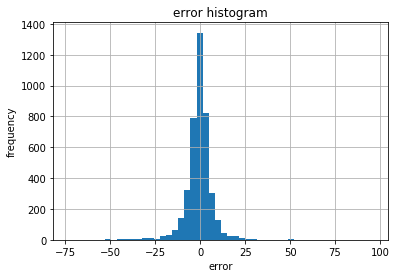

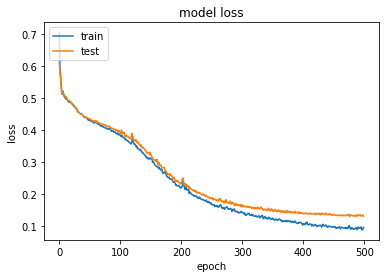

,0
count,4125.000000
mean,-0.755018
std,7.414853
min,-73.178917
25%,-3.468590
50%,-0.437002
75%,2.314013
max,96.130581


In [7]:
def ai_errors(predictions, observations, history = None) :
    '''
    PURPOSE: Provide descriptive statistics on the predicted output versus the observed measurments
    METHOD:  Take the errors of the predictions and answers and then calculate standard descriptive statistics
    INPUT:   predictions - 2D array of predictions of observed output
             observations - 2D array measurements of observed output
             history - Keras history model for displaying model loss, default is None if not available
    OUTPUT:
    '''
    errors = []
    for i in range(len(predictions)) :
        for j in range(len(predictions[i])) :
            # Calculate errors
            error = predictions[i][j] - observations[i][j]
            errors.append(error)
    
    # Display history and erros
    plt.figure(1)
    plt.hist(errors, bins = 50)
    plt.title('error histogram')
    plt.xlabel('error')
    plt.ylabel('frequency')
    plt.grid(True)
    
    plt.figure(2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return pd.DataFrame(errors)

# Predict values
wind_predictions = model_wind.predict(X_test)
lat_predictions = model_lat.predict(X_test)
long_predictions = model_long.predict(X_test)

# Scale back our predictions
# Wind
wind_predictions_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0] for winds in prediction])
                           for prediction in wind_predictions]
y_wind_test_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0] for winds in observation])
                      for observation in y_test_wind]
# Latitude
lat_predictions_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0,0] for lat in prediction])
                          for prediction in lat_predictions]
y_lat_test_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0,0] for lat in observation])
                     for observation in y_test_lat]
# Longitude
long_predictions_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0,0] for long in prediction])
                           for prediction in long_predictions]
y_long_test_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0,0] for long in observation])
                      for observation in y_test_long]

# Record wind predictions and observations
print("Wind")
wind_predictions = [[pred[2] for pred in hurricanes_pred] for hurricanes_pred in wind_predictions_scaled]
wind_observations = [[obsrv[2] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_wind_test_scaled]

# Present Errors
ai_errors(wind_predictions, wind_observations, model_wind_history).describe()

Lat


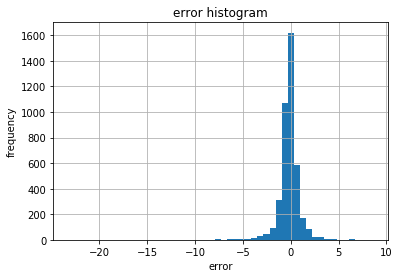

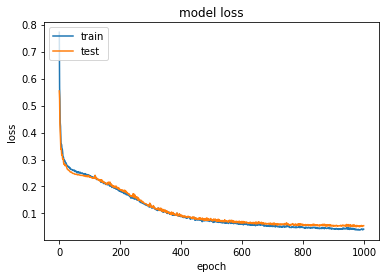

,0
count,4125.000000
mean,-0.176181
std,1.206441
min,-23.217871
25%,-0.545974
50%,-0.141917
75%,0.265006
max,8.609077


In [8]:
print("Lat")
lat_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in lat_predictions_scaled]
lat_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_lat_test_scaled]
ai_errors(lat_predictions, lat_observations, model_lat_history).describe()

Long


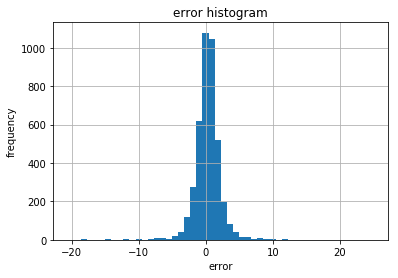

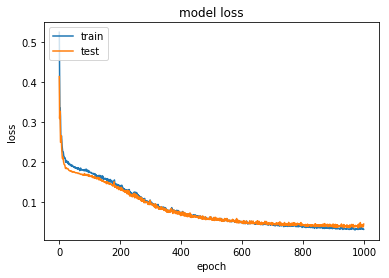

,0
count,4125.000000
mean,0.283128
std,1.986305
min,-20.484958
25%,-0.614819
50%,0.300115
75%,1.184537
max,24.931866


In [9]:
print("Long")
long_predictions = [[pred[1] for pred in hurricanes_pred] for hurricanes_pred in long_predictions_scaled]
long_observations = [[obsrv[1] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_long_test_scaled]
ai_errors(long_predictions, long_observations, model_long_history).describe()

## Model Evaluation & Benchmarks<a id="Benchmarks"></a>

The machine learning neural network will use 2 main methods of applied evaluation. The first will be evaluated compared to the other models that predict Atlantic hurricanes. The forecast errors have been loaded into each hurricane object corresponding to their forecast model; both the OFCL (official track, or the truth) and the BCD5 (model using multivariate regression). The BCD5 model is "the CLP5 (track) and DSF5 (intensity) models merged" that uses the best track as input.

In [14]:
# Filter storms that have more than 6 entries. We need at least 6 to calculate 5 speed vectors
storms_filter = [storm for storm in hurricanes.values() if len(storm.entries) > 6]

# Create hurricane forecast and track predictions
for storm in storms_filter :
    # Create inputs to ai. ai requires scaled data as input
    entries = [entry[1] for entry in sorted(storm.entries.items())] # Extracts data from data structure
    print("*******************************************************************************************")
    pprint(entries)
    inputs = [scaler.transform([np.array(list(feature_extraction(entries[index], entries[index - 1]).values()))
                                for index in range(start_index, start_index + 5)])
                for start_index in range(1, len(entries) - 5)]

*******************************************************************************************
[{'entry_id': '',
  'entry_status': 'HU',
  'entry_time': Timestamp('1851-06-25 00:00:00'),
  'lat': 28.0,
  'long': 94.8,
  'max_wind': 80.0,
  'min_pressure': None,
  'wind_radii': 34kt_ne    None
34kt_se    None
34kt_sw    None
34kt_nw    None
50kt_ne    None
50kt_se    None
50kt_sw    None
50kt_nw    None
64kt_ne    None
64kt_se    None
64kt_sw    None
64kt_nw    None
Name: 0, dtype: object},
 {'entry_id': '',
  'entry_status': 'HU',
  'entry_time': Timestamp('1851-06-25 06:00:00'),
  'lat': 28.0,
  'long': 95.4,
  'max_wind': 80.0,
  'min_pressure': None,
  'wind_radii': 34kt_ne    None
34kt_se    None
34kt_sw    None
34kt_nw    None
50kt_ne    None
50kt_se    None
50kt_sw    None
50kt_nw    None
64kt_ne    None
64kt_se    None
64kt_sw    None
64kt_nw    None
Name: 1, dtype: object},
 {'entry_id': '',
  'entry_status': 'HU',
  'entry_time': Timestamp('1851-06-25 12:00:00'),
  'lat': 28.0,
 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').